# Table of Contents
 <p><div class="lev1"><a href="#Modules,-functions,-results,-variables"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modules, functions, results, variables</a></div><div class="lev1"><a href="#CRM-level-mass-flux"><span class="toc-item-num">2&nbsp;&nbsp;</span>CRM-level mass flux</a></div><div class="lev2"><a href="#Compare-mass-flux-in-the-wet-and-dry-areas"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Compare mass flux in the wet and dry areas</a></div>

# Modules, functions, results, variables

Modules

In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from mpl_toolkits.basemap import Basemap
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from netCDF4 import Dataset
from math import *
import glob
import string
import re
from datetime import date, time, datetime
from pprint import pprint
import sys,os
import csv
import pandas as pd
import pickle
import matplotlib.transforms as mtransforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths

In [2]:
# Add ../functions to system path
currentpath = %pwd
currentpath = str(currentpath)
##-- In a python script do the following instead:
##-- currentpath = os.path.dirname(os.path.realpath(__file__))
sys.path.insert(0,currentpath[:currentpath.rfind('/')+1]+'functions')

## Fixed data files input directory
inputdir_fx = '/Users/bfildier/Data/preprocessed/allExperiments/fx'
## Dataframe input directory
# resultdir = os.path.join(os.path.dirname(currentpath),'results')
resultdir = os.path.join(os.path.dirname(currentpath),'results/fullResults')
## Maps (2D tropical data files) input directory
inputdir_maps = os.path.join(os.path.dirname(currentpath),'inputs/forMaps')
inputdir_processed = os.path.join(os.path.dirname(currentpath),'inputs/fullDataPreprocessed')
inputdir_results = os.path.join(os.path.dirname(currentpath),'results')

##-- Output directories --##
## Figures
figdir = os.path.join(os.path.dirname(currentpath),'figures/fullResults')


Graphical parameters

In [3]:
###--- Set up graphical parameters ---###

##-- Figure setup --##
plt.rcParams.update({'axes.labelsize': 'x-large',
                     'axes.titlesize': 'x-large',
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'figure.titlesize': 'xx-large',
                     'figure.subplot.top': '0.87',
                     'figure.subplot.wspace': '0.3',
                     'figure.subplot.hspace': '0.3',
                     'legend.fontsize':'medium'})

##-- Load colors for plots --##
colorfile = os.path.join(currentpath,'colorsAndTypes.pickle')
with open(colorfile,'rb') as handle:
    col = pickle.load(handle)
    lt = pickle.load(handle)
    pal = pickle.load(handle)
    lw = pickle.load(handle)
    dashes = pickle.load(handle)
    mark = pickle.load(handle)
    cmaps = pickle.load(handle)

Own modules and functions

In [4]:
from importingData import *
from extremeScaling import *
from thermodynamics import *
from thermo_funcs import *
from thermo_constants import *

Additional functions

In [5]:
# Import the CRM-level column-integrated mass flux values in the dry or wet regions
def importCRMMassFlux(pr_id,area_id,q_id,experiment,dry=False):
    if dry:
        mf_id = "CRM_MFdry_%s_%s_%s"%(area_id,pr_id,q_id)    
    else:
        mf_id = "CRM_MF_%s_%s_%s"%(area_id,pr_id,q_id)
    print mf_id
    case = "bf_%s_%s"%(compset_SPCAM,experiment)
    inputdir = os.path.join(inputdir_processed,case,'1hr')
    files = getInputfiles(mf_id,inputdir)
    mf_list = getVar(mf_id,inputdir,inputfiles=files)
    inc_list = getVar("isNewCell",inputdir,inputfiles=files)
    return mf_list, inc_list

# Compute daily mean MF in wet and dry regions, keep the daily structure
def computeCRMMF(mf_list,inc_list):
    mf_mean = []
    for i in range(len(inc_list)):
        inc = inc_list[i][0]
        mf = mf_list[i][0]
        cellStarts = tuple(np.where(np.array(inc) == 1)[0])
        mf_mean.append([])
        if len(cellStarts) > 0:
            cellStarts = cellStarts[1:]+(-1,)
        k_0 = 0
        for k in cellStarts:
            if k != -1:
                mf_mean[i].append(np.mean(mf[k_0:k]))
            else:
                mf_mean[i].append(np.mean(mf[k_0:]))
            k_0 = k
    return mf_mean

## Filter before plotting
def filter121(var1D):
    var1D = np.array(var1D,dtype=float)
    var_filt = 0.25*var1D[:-2] + 0.5*var1D[1:-1] + 0.25*var1D[2:]
    return np.hstack([np.array(np.nan),var_filt,np.array(np.nan)])

Global variables and datasets

In [14]:
###--- Datasets ---###

## Dataset parameter sets and variable sets
compsets = ("FSPCAMm_AMIP","FAMIPC5")
experiments = ("piControl","abrupt4xCO2")
subsets = ("tropics","ocean","land","mfzero")
subsets_for_comp = dict(zip(compsets,(subsets,subsets[:-1])))

## Individual names
compset_SPCAM, compset_CAM5 = compsets
experiment_PI, experiment_4xCO2 = experiments
subset_all, subset_ocean, subset_land, subset_mf = subsets


##--- Related to scaling ---##

## Simulation vs. pr scaling
pr_types = ["simulated","scaling"]
## Contributions to fractional changes
# contributions = ["mass","thermo","dyn_mean","dyn_profile","pressure","non_linear","all"]
# contributions_labs = ["Mass","Thermodynamic",r"Mass flux",r"Profile shift","Pressure","Non linear","Sum"]
contributions = ["thermo","dyn_mean","dyn_mean_th","dyn_mean_dyn","dyn_profile","non_linear","all"]
contributions_labs = ["Thermodynamic",r"Mass flux",r"Mass flux ($\Delta \rho$)",r"Mass flux ($\Delta w$)",
                      r"Profile shift","Non linear","Sum"]
contributions_labels = dict(zip(contributions,contributions_labs))

###--- Variables ids ---###

## All pr ids
pr_ids = ["PRECT","CRM_PREC_I90","CRM_PREC_I75","CRM_PREC_I50","CRM_PREC_I25","CRM_PREC_I10"]
gcm_pr_id = pr_ids[0]
crm_pr_ids = pr_ids[1:]
pr_ids_for_compset = {compsets[0]:pr_ids, compsets[1]:[gcm_pr_id]}

area_id_root = "PRECAREA_"
area_ids = [area_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

frac_id_root = "PRECFRAC_"
frac_ids = [frac_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

## Define IDs of variables required for plotting profiles
varids_for_profiles = {"PRECT":('PS','T','Q','RELHUM','OMEGA','W')}
for f in [90,75,50,25,10]:
#     varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_QC_I%s'%str(f),'CRM_H_I%s'%str(f),
#                                            'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))
    varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'Q','CRM_H_I%s'%str(f),
                                           'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))

## Define IDs of variables required for computing scaling
varids_for_scaling = {"PRECT":('PS','T','OMEGA','W')}
for f in [90,75,50,25,10]:
    varids_for_scaling["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))

## Define percentile values
Q_IL_ext = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987,99.999])
Qs = [90.,96.8377,99.,99.6838,99.9,99.9684,99.99,99.9968]
Q_ids = ['90.0','96.8377','99.0','99.6838','99.9','99.9684','99.99','99.9968']

###--- Legends, titles and labels ---###
    
## Corresponding legend labels
compset_labs = ["SPCAM","CAM5"]
compset_labels = dict(zip(compsets,compset_labs))

exp_labs = ["Pre-industrial","4xCO2"]
exp_labels = dict(zip(experiments,exp_labs))

subset_labs = ["Tropics","Tropical oceans","Tropical land","Zero mass flux"]
subset_labels = dict(zip(subsets,subset_labs))

pr_labs = [r"$P(GCM)$",r"$P(CRM)$ largest $90\%$",r"$P(CRM)$ largest $75\%$",r"$P(CRM)$ largest $50\%$",
             r"$P(CRM)$ largest $25\%$",r"$P(CRM)$ largest $10\%$"]
pr_labels = dict(zip(pr_ids,pr_labs))
pr_labs_short = [r"$P(GCM)$",r"${\left[P(CRM)\right]}^{90\%}$",r"${\left[P(CRM)\right]}^{75\%}$",
                 r"${\left[P(CRM)\right]}^{50\%}$",
             r"${\left[P(CRM)\right]}^{25\%}$",r"${\left[P(CRM)\right]}^{10\%}$"]
pr_labels_short = dict(zip(pr_ids,pr_labs_short))
pr_labs_veryshort = [r"$P_{GCM}$",r"$P_{CRM}^{90\%}$",r"$P_{CRM}^{75\%}$",
                 r"$P_{CRM}^{50\%}$",r"$P_{CRM}^{25\%}$",r"$P_{CRM}^{10\%}$"]
pr_labels_veryshort = dict(zip(pr_ids,pr_labs_veryshort))
pr_labs_vvshort = [r"$P_{GCM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$"]
pr_labels_vvshort = dict(zip(pr_ids,pr_labs_vvshort))


###--- Results and others ---###

## Vertical pressure coordinate function
lev_file = 'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'
computeP = getPressureCoordinateFunction(os.path.join(inputdir_fx,lev_file))

## Import all dataframes
# df_quantile = getStatDataFrame("pr_quantile_IL",compsets,experiments,subsets,resultdir)
# df_density2D = getStatDataFrame("pr_jointDensity_IL",compsets,experiments,subsets,resultdir)
# df_mean = getStatDataFrame("var2D_mean",compsets,experiments,subsets,resultdir)
# df_meanProfile = getStatDataFrame("var3D_meanProfile",compsets,experiments,subsets,resultdir)
# df_meanAtQ = getStatDataFrame("var2D_meanAtQ",compsets,experiments,subsets,resultdir)
# df_meanProfileAtQ = getStatDataFrame("var3D_meanProfileAtQ",compsets,experiments,subsets,resultdir)

# CRM-level mass flux

In [7]:
# Import 
pr_id = "CRM_PREC_I50"
pr_ids_to_plot = ["PRECT","CRM_PREC_I50"]
area_id = "I50"
q_id = "999000"
experiment = experiment_PI

CRM_MF_I50_PRECT_999000
(1, 33923)
-0.227291756992 -0.584264806663
CRM_MF_I50_PRECT_999000
(1, 30939)
-0.459198976557 -0.9649215404
CRM_MF_I50_CRM_PREC_I50_999000
(1, 5435)
-0.936533083341 -1.2746054915
CRM_MF_I50_CRM_PREC_I50_999000
(1, 6974)
-1.32419697219 -1.82917116975


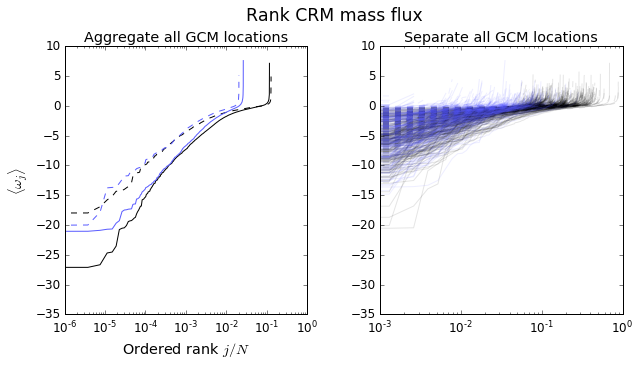

In [8]:
fig, (ax0,ax1) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))

for pr_id in pr_ids_to_plot:
    for experiment in experiments:

        mf_list, inc_list = importCRMMassFlux(pr_id,area_id,q_id,experiment)
        print np.hstack(mf_list).shape
        mf_array = np.hstack(mf_list).squeeze()
        print mf_array.mean(), mf_array[mf_array<0].mean()
        inc_array = np.hstack(inc_list).squeeze()
        Ncol = inc_array.size
        Ncells = inc_array.sum()
        mf_array.sort()
        f = np.arange(Ncol)/float(Ncells)/32/24
#         f = np.arange(Ncol)/float(Ncells)
        ax0.plot(f,mf_array,linestyle=lt[experiment],c=col[pr_id])
        ## Plot GCM cell per GCM cell
        for t in range(len(mf_list)):
            for i in range(len(mf_list[t])):
                fi = np.arange(len(mf_list[t][i]))/24./32.
                mf_list[t][i].sort()
                ax1.plot(fi,mf_list[t][i],linestyle=lt[experiment],c=col[pr_id],alpha=0.1)
#                 ax1.plot(fi,mf_list[i])

ax0.set_xscale('log')
ax0.set_xlabel(r'Ordered rank $j/N$')
ax0.set_ylabel(r'$\langle\omega_j\rangle$')
ax0.set_title("Aggregate all GCM locations")

ax1.set_xscale('log')
ax1.set_title("Separate all GCM locations")

plt.suptitle("Rank CRM mass flux")
plt.show()

For paper

CRM_MF_I50_CRM_PREC_I50_999000
CRM_MF_I50_CRM_PREC_I50_999000


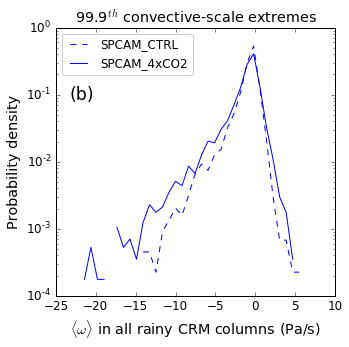

In [43]:
fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

pr_ids_to_plot = ["CRM_PREC_I50"]

bins = np.linspace(-30,10,num=50)
labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}

cols = {False:'b',True:'g'}

for pr_id in pr_ids_to_plot:
    for experiment in experiments:
        for dry in (False, ):
            
            mf_list, inc_list = importCRMMassFlux(pr_id,area_id,q_id,experiment,dry)
            mf_array = np.hstack(mf_list).squeeze()
            inc_array = np.hstack(inc_list).squeeze()
            Ncol = inc_array.size
            Ncells = inc_array.sum()
            mf_array.sort()
            f = np.arange(Ncol)/float(Ncells)/32/24
            mf_Hd, mf_e = np.histogram(mf_array,bins=bins,density=True)
            mf_Hd[mf_Hd == 0] = None
            mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
            # Plot
    #         lab = "%s, for %s"%(exp_labels[experiment],pr_labels_vvshort[pr_id])
            lab = labels[experiment]
            ax0.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=cols[dry],label=lab)

ax0.set_yscale('log')
ax0.set_ylim((1e-4,1))
ax0.set_xlabel(r'$\langle\omega\rangle$ in all rainy CRM columns (Pa/s)')
ax0.set_ylabel(r'Probability density')
ax0.set_title(r"%2.1f$^{th}$ convective-scale extremes"%(float(q_id)/10000.))
ax0.legend(loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,framealpha=0.2,fancybox=True,fontsize=12)

# # Customized legend
# cold = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
# warm = plt.Line2D((0,1),(0,0), color='k')
# labs = (l.get_label() for l in ln)
# ax0.legend([cold,warm],labs,loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,fontsize=12,framealpha=0.2,fancybox=True)

## Add letter label
trans2 = mtransforms.blended_transform_factory(ax0.transAxes, ax0.transAxes)
ax0.text(0.05,0.73,"(b)",fontsize='xx-large',transform=trans2)

plt.savefig(os.path.join(figdir,"fig_paper_CRMmassfluxPDF_wet_%s_%s_%s.pdf"%(q_id,string.join(pr_ids_to_plot,'_'),
                                                                             string.join(list(experiments),'_'))),
                        bbox_inches='tight')

CRM_MF_I50_CRM_PREC_I50_999000
CRM_MFdry_I50_CRM_PREC_I50_999000
CRM_MF_I50_CRM_PREC_I50_999000
CRM_MFdry_I50_CRM_PREC_I50_999000


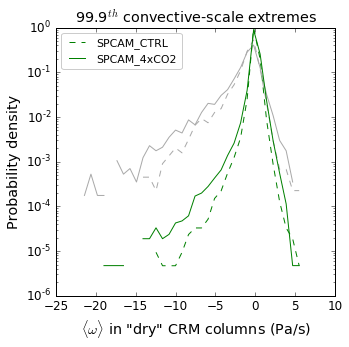

In [46]:
fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

pr_ids_to_plot = ["CRM_PREC_I50"]

bins = np.linspace(-30,10,num=50)
labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}

cols = {False:'darkgrey',True:'g'}

ln = []
for pr_id in pr_ids_to_plot:
    for experiment in experiments:
        for dry in (False, True):
            
            mf_list, inc_list = importCRMMassFlux(pr_id,area_id,q_id,experiment,dry)
            mf_array = np.hstack(mf_list).squeeze()
            inc_array = np.hstack(inc_list).squeeze()
            Ncol = inc_array.size
            Ncells = inc_array.sum()
            mf_array.sort()
            f = np.arange(Ncol)/float(Ncells)/32/24
            mf_Hd, mf_e = np.histogram(mf_array,bins=bins,density=True)
            mf_Hd[mf_Hd == 0] = None
            mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
            # Plot
    #         lab = "%s, for %s"%(exp_labels[experiment],pr_labels_vvshort[pr_id])
            lab = labels[experiment]
            h = ax0.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=cols[dry],label=lab)
            if dry:
                ln = ln + h

ax0.set_yscale('log')
# ax0.set_ylim((1e-4,1))
ax0.set_xlabel(r'$\langle\omega\rangle$ in "dry" CRM columns (Pa/s)')
ax0.set_ylabel(r'Probability density')
ax0.set_title(r"%2.1f$^{th}$ convective-scale extremes"%(float(q_id)/10000.))
# ax0.legend(loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,framealpha=0.2,fancybox=True,fontsize=12)
labs = (l.get_label() for l in ln)
ax0.legend(ln,labs,loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,framealpha=0.2,fancybox=True,fontsize=11)

# # Customized legend
# cold = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
# warm = plt.Line2D((0,1),(0,0), color='k')
# labs = (l.get_label() for l in ln)
# ax0.legend([cold,warm],labs,loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,fontsize=12,framealpha=0.2,fancybox=True)

## Add letter label
# trans2 = mtransforms.blended_transform_factory(ax0.transAxes, ax0.transAxes)
# ax0.text(0.05,0.73,"(b)",fontsize='xx-large',transform=trans2)

plt.savefig(os.path.join(figdir,"fig_paper_CRMmassfluxPDF_dry_%s_%s_%s.pdf"%(q_id,string.join(pr_ids_to_plot,'_'),
                                                                             string.join(list(experiments),'_'))),
                        bbox_inches='tight')

For AOFD talk

CRM_MF_I50_CRM_PREC_I50_999000
CRM_MF_I50_CRM_PREC_I50_999000


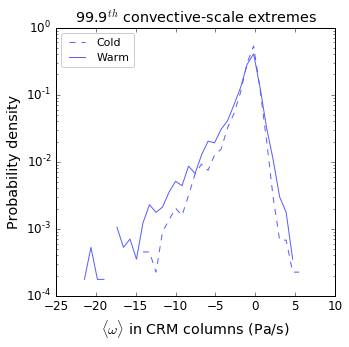

In [23]:
fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

pr_ids_to_plot = ["CRM_PREC_I50"]
# pr_ids_to_plot = ["PRECT"]

bins = np.linspace(-30,10,num=50)
labels = {experiment_PI:"Cold",experiment_4xCO2:"Warm"}

for pr_id in pr_ids_to_plot:
    for experiment in experiments:

        mf_list, inc_list = importCRMMassFlux(pr_id,area_id,q_id,experiment)
        mf_array = np.hstack(mf_list).squeeze()
        inc_array = np.hstack(inc_list).squeeze()
        Ncol = inc_array.size
        Ncells = inc_array.sum()
        mf_array.sort()
        f = np.arange(Ncol)/float(Ncells)/32/24
        mf_Hd, mf_e = np.histogram(mf_array,bins=bins,density=True)
        mf_Hd[mf_Hd == 0] = None
        mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
        # Plot
#         lab = "%s, for %s"%(exp_labels[experiment],pr_labels_vvshort[pr_id])
        lab = labels[experiment]
        ax0.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=col[pr_id],label=lab)

ax0.set_yscale('log')
ax0.set_xlabel(r'$\langle\omega\rangle$ in CRM columns (Pa/s)')
ax0.set_ylabel(r'Probability density')
ax0.set_title(r"%2.1f$^{th}$ convective-scale extremes"%(float(q_id)/10000.))
ax0.legend(loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,framealpha=0.2,fancybox=True,fontsize=11)

plt.savefig(os.path.join(figdir,"fig_AOFD_CRMmassfluxPDF_%s_%s_%s.pdf"%(q_id,string.join(pr_ids_to_plot,'_'),
                                                                             string.join(list(experiments),'_'))),
                        bbox_inches='tight')

## Compare mass flux in the wet and dry areas

CRM_PREC_I50 piControl False
CRM_MF_I50_CRM_PREC_I50_999000
CRM_PREC_I50 piControl True
CRM_MFdry_I50_CRM_PREC_I50_999000
CRM_PREC_I50 abrupt4xCO2 False
CRM_MF_I50_CRM_PREC_I50_999000
CRM_PREC_I50 abrupt4xCO2 True
CRM_MFdry_I50_CRM_PREC_I50_999000


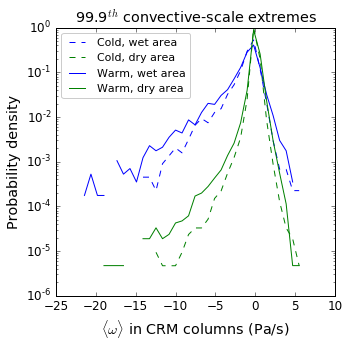

In [44]:
fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

pr_ids_to_plot = ["CRM_PREC_I50"]
# pr_ids_to_plot = ["PRECT"]

bins = np.linspace(-30,10,num=50)
labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}
# labels = {experiment_PI:"Cold",experiment_4xCO2:"Warm"}

c = {False:'b',True:'g'}

for pr_id in pr_ids_to_plot:
    for experiment in experiments:
        for dry in (False, True):
#         for dry in (False,):
            
            print pr_id, experiment, dry

            mf_list, inc_list = importCRMMassFlux(pr_id,area_id,q_id,experiment,dry)
            if mf_list is None:
                continue
            mf_array = np.hstack(mf_list).squeeze()
            inc_array = np.hstack(inc_list).squeeze()
            Ncol = inc_array.size
            Ncells = inc_array.sum()
            mf_array.sort()
            f = np.arange(Ncol)/float(Ncells)/32/24
            mf_Hd, mf_e = np.histogram(mf_array,bins=bins,density=True)
            mf_Hd[mf_Hd == 0] = None
            mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
            # Plot
    #         lab = "%s, for %s"%(exp_labels[experiment],pr_labels_vvshort[pr_id])
    #             lab = labels[experiment]
            if dry:
                lab = "%s, dry area"%labels[experiment]
            else:
                lab = "%s, wet area"%labels[experiment]

            ax0.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=c[dry],label=lab)

ax0.set_yscale('log')
ax0.set_xlabel(r'$\langle\omega\rangle$ in CRM columns (Pa/s)')
ax0.set_ylabel(r'Probability density')
ax0.set_title(r"%2.1f$^{th}$ convective-scale extremes"%(float(q_id)/10000.))
ax0.legend(loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,framealpha=0.2,fancybox=True,fontsize=11)

plt.savefig(os.path.join(figdir,"fig_paper_CRMmassfluxPDF_%s_%s_%s.pdf"%(q_id,string.join(pr_ids_to_plot,'_'),
                                                                             string.join(list(experiments),'_'))),
                        bbox_inches='tight')

CRM_MF_I50_CRM_PREC_I50_999000
-0.92862927642
CRM_MFdry_I50_CRM_PREC_I50_999000
0.0198376976658
CRM_MF_I50_CRM_PREC_I50_999000
-1.42036896982
CRM_MFdry_I50_CRM_PREC_I50_999000
0.0362811859707
Mass flux contribution: 12.5389187513


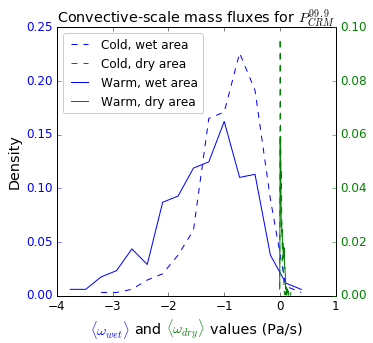

In [20]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

pr_ids_to_plot = ["CRM_PREC_I50"]

bins = np.linspace(-5,3,num=30)
bins_dry = np.linspace(-0.05,0.2,num=100)
# labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}
labels = {experiment_PI:"Cold",experiment_4xCO2:"Warm"}

c = {False:'b',True:'g'}

fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))
ax0.tick_params('y', colors=c[False])
ax1 = ax0.twinx()
ax1.tick_params('y', colors=c[True])

ln = []
mf_mean = {}
for pr_id in pr_ids_to_plot:
    mf_mean[pr_id] = {}
    for experiment in experiments:
        mf_mean[pr_id][experiment] = {}
        for dry in (False, True):
#         for dry in (False,):
            
            # Get mass flux values
            mf_list, inc_list = importCRMMassFlux(pr_id,area_id,q_id,experiment,dry)
            mf_means = computeCRMMF(mf_list,inc_list)
            mf_array = np.hstack(mf_means).squeeze()
            mf_mean[pr_id][experiment][dry] = mf_array.mean()
            print mf_array.mean()
            
            if not dry:
                # Compute histograms
                mf_Hd, mf_e = np.histogram(mf_array,bins=bins,density=True)
                mf_Hd = mf_Hd/float(mf_Hd.sum())
#                 mf_Hd = filter121(mf_Hd)
#                 mf_Hd = filter121(filter121(mf_Hd))
                mf_Hd[mf_Hd == 0] = None
                mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
                # Plot
                lab = "%s, wet area"%labels[experiment]
                ln = ln + ax0.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=c[dry],label=lab)
            else:
                # Compute histograms
                mf_Hd, mf_e = np.histogram(mf_array,bins=bins_dry,density=True)
                mf_Hd = mf_Hd/float(mf_Hd.sum())
                mf_Hd = filter121(filter121(mf_Hd))
                mf_Hd[mf_Hd == 0] = None
                mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
                # Plot
                lab = "%s, dry area"%labels[experiment]
                ln = ln + ax1.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=c[dry],label=lab)
                
ax0.set_xlim((-4,1))
ax0.set_title("Convective-scale mass fluxes for $P_{CRM}^{99.9}$")
ax0.set_ylabel("Density")
# ax1.set_ylabel("Averaged over the dry region",color=c[True])

### x-axis legend with colors
xbox1 = TextArea(r"$\langle\omega_{wet}\rangle$", textprops=dict(color=c[False],size="x-large",ha='left',va='center'))
xbox2 = TextArea(r"and", textprops=dict(color="k",size="x-large",ha='left',va='center'))
xbox3 = TextArea(r"$\langle\omega_{dry}\rangle$", textprops=dict(color=c[True],size="x-large",ha='left',va='center'))
xbox4 = TextArea(r"values (Pa/s)", textprops=dict(color="k",size="x-large",ha='left',va='center'))

xbox = HPacker(children=[xbox1, xbox2, xbox3,xbox4], align='baseline', pad=0, sep=5)

anchored_xbox = AnchoredOffsetbox(loc=8, child=xbox, pad=0., frameon=False, bbox_to_anchor=(0.5,-0.15), 
                                  bbox_transform=ax0.transAxes, borderpad=0.)
ax0.add_artist(anchored_xbox)

labs = (l.get_label() for l in ln)
ax0.legend(ln, labs, loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,fontsize=12,framealpha=0.2,fancybox=True)

# Compute mass flux contribution
dts = 4.223114014
print "Mass flux contribution:", (mf_mean["CRM_PREC_I50"][experiment_4xCO2][False]/mf_mean["CRM_PREC_I50"][experiment_PI][False] - 1.)*100./dts

# plt.savefig(os.path.join(figdir,"fig_paper_DailyCRMmassfluxPDF_wet_and_dry_%s_%s_%s.pdf"%(q_id,string.join(pr_ids_to_plot,'_'),
#                                                                              string.join(list(experiments),'_'))),
#                         bbox_inches='tight')

Plot PDF of product of means $\rho_j w_j$

In [118]:
compset = compset_SPCAM
experiment = experiment_PI
subsetName = 'tropics'


# Get J-values corresponding to 99.9th percentile
# Index J of quantile
case = "bf_%s_%s"%(compset,experiment)
inputdir_processed_day = os.path.join("/Users/bfildier/Data",'preprocessed',case,'day')
percfile = "pr_quantile_IL_%s_%s_%s.csv"%(compset,experiment,subsetName)
df_perc = pd.read_csv(os.path.join(inputdir_results,percfile))
Qs = np.array([float(Q) for Q in df_perc['Q_IL']])
J = np.argmin(np.absolute(Qs-float(q_id)))
J_id = "J_%s"%(pr_id)
# J_vals = getVar(J_id,inputdir_processed_day,dates=(datetime1,datetime2))[0]
J_vals = getVar(J_id,inputdir_processed_day)[0]
J_valid = np.array(J_vals == J,dtype=bool)
    
# Extract profiles of convective-scale rho and w at these locations


In [119]:
print J_vals.shape

(32, 144)
